# Кодирование и обучение в спайковых нейронных сетях

Нестерова Мария.

В этой домашней работе нужно сравнить две способа кодирования информации: частотный и временной.

## Задание
* Сгенерируйте обучающую и тестовую выборки простых изображений размером 3 на 3 пикселя
* Реализуйте два типа кодирования: частотой спайков и временем до первого спайка (TTFS). Использовать ноутбук к семинару про кодирование.  
* Обучите две сети по правилу STDP. Архитектуру сети можно взять из семинара по классификации. Вероятно, придется выбрать разные значения параметров для правила STDP.
* Сравните качество классификации по метрикам accuracy и F-measure

## References

[1] Diehl, P. U., & Cook, M. (2015). Unsupervised learning of digit recognition using spike-timing-dependent plasticity. Frontiers in computational neuroscience, 9, 99 

[2] https://www.kaggle.com/code/dlarionov/mnist-spiking-neural-network/notebook

## Библиотеки

In [1]:
!pip install brian2
!pip install --upgrade numpy
!pip install matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 1.1 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.5 which is incompatible.
     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 16.4/40.9 MB 97.5 kB/s eta 0:04:12
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/mac-julia/opt/anaconda3/lib/python3.9/site-packages/pip/_vendor/urllib3/response.py", line 437, in _error_catcher
    yield
  File "/Users/mac-julia/opt/anaconda3/lib/python3.9/site-pac

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import brian2 as b2

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


/Users/mac-julia/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Генерация обучающей и тестовой выборки


Можно использоватьготовые паттерны

In [3]:
plus = np.array([1, 1, 1,
                 0, 0, 0,
                 0, 0, 0]).reshape(3,3)
cross = np.array([0, 0, 0,
                  0, 0, 0,
                  1, 1, 1]).reshape(3,3)
patterns = [plus, cross]

Создание случайного паттерна

In [4]:
N_p = 4 # Количество паттернов
size = 9
patterns = []
seeds = [94, 350, 377, 36, 216, 99, 59, 317] # 
seeds = [94, 36,  59, 317, 369, 2, 813, 776]
seeds = [36, 59, 2, 813]
for i in range(N_p):
    pattern = np.zeros(9)
    s = np.random.randint(900) #
    s = seeds[i]
    print(s)
    rng = np.random.default_rng(seed=s)
    n_p = int(rng.choice([2,3,4,5], 1, p=[0.2, 0.3, 0.4, 0.1], replace=False))
    indx = rng.choice(size, n_p, replace=False).astype(int)
    pattern[indx] = 1
    patterns.append(pattern.reshape(3,3))
    print(pattern.reshape(3,3))
    print()

36
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

59
[[0. 1. 0.]
 [0. 1. 1.]
 [0. 1. 0.]]

2
[[1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]]

813
[[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]



Изображение получившихся паттернов

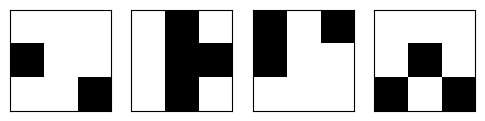

In [5]:
def draw_patterns(patterns, figsize=(6,4)):
  fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=figsize)
  for i,p in enumerate(patterns):
    ax[i].imshow(patterns[i], cmap='Greys')
    ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

draw_patterns(patterns)

Генерация обучающей и тестовой выборки

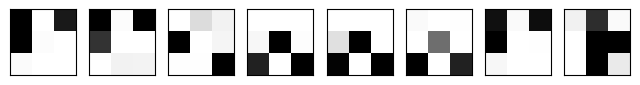

In [6]:
from sklearn.model_selection import train_test_split
N_SAMPLE_CLASS = 30
# N_SAMPLE_CLASS = 10
rng = np.random.default_rng()
X,y = [],[]
sigma = 0.15
for i_p,p in enumerate(patterns):
  for _ in range(N_SAMPLE_CLASS):
    X += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
    y += [i_p]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
draw_patterns(X_train[-8:], figsize=(8,5))

# Основные функции по созданию, обучению сети


Параметры

In [7]:
taum = 10*b2.ms
taue = 5*b2.ms
taui = 10*b2.ms
v_rest = -74*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
Ee = 0*b2.mV
Ei = -100*b2.mV

In [8]:
taupre=20*b2.ms
taupost=20*b2.ms
gmax=0.2
gmin=0.05
gi_max = gmax
max_delay_i = 10*b2.ms
dApre=0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

Основные функции для создания сети

In [9]:
def create_input_PG(size): # 1
  input_group = b2.PoissonGroup(size, rates=np.zeros(size)*b2.Hz, 
                              name='PG')  
  s_mon_inp = b2.SpikeMonitor(input_group)
  return input_group, s_mon_inp

def create_input_SGG(size): # 2
  input_group = b2.SpikeGeneratorGroup(size, indices = [],
                                       times=[]*b2.ms, name='SG')  
  s_mon_inp = b2.SpikeMonitor(input_group)
  return input_group, s_mon_inp

def create_exc_neurons(size):
  neuron_eq = '''
            dv/dt = (v_rest - v + ge * (Ee - v) + gi * (Ei - v)) / taum : volt
            dge/dt = -ge / taue : 1
            dgi/dt = -gi / taui : 1
            '''
  neurons = b2.NeuronGroup(size, neuron_eq, threshold='v>vt', reset='v = vr',
                      method='euler')
  neurons.v = v_rest
  neurons.ge=0
  neurons.gi=0
  s_mon_nrn = b2.SpikeMonitor(neurons)
  return neurons, s_mon_nrn


def create_stdp_synapses(pre_group, post_group):
  S = b2.Synapses(pre_group, post_group,
             '''w : 1
                stdp_rate : 1 (shared)
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + stdp_rate*Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + stdp_rate*Apre, 0, gmax)''',
             )
  S.connect()
  S.w = 'rand() * gmax'
  S.stdp_rate = 1
  mon = b2.StateMonitor(S, 'w', record=True)
  return S, mon

def create_inh_synapses(neuron_group):
    # тормозящие синапсы с задержкой   
  S = b2.Synapses(neuron_group, neuron_group,
             '''w : 1
                ''',
             on_pre='''gi += w''',
             )
  S.connect('i!=j')
  S.delay = "max_delay_i*rand()"
  S.w = gi_max  
  return S


Определение класса

In [10]:
def predict(rates, neuron_class):
  y = np.ones(rates.shape[0])*np.nan
  for i,x in enumerate(rates):
    y[i] = neuron_class[np.argmax(x)]
  return y

Качество классификации

In [11]:
def all_metrics(prediction, y):
    print(f'Количество несовпадающих объектов {np.sum((prediction - y) != 0)} из {prediction.shape[0]} ({int(np.sum((prediction - y) != 0) / prediction.shape[0]*100)} %)')
    acc = accuracy_score(y, prediction)
    cm = confusion_matrix(y, prediction)
    print(f"Accuracy: {acc}")
    cm_display = ConfusionMatrixDisplay(cm).plot()
    f1 = f1_score(y, prediction, average='weighted')
    print(f"f_1: {f1}")

Прорисовывание весов

In [12]:
def plot_synapses(n_source, n_target, synapses, title=""):
  plt.figure(figsize=(3,3))
  W = np.full((n_source, n_target), np.nan)
  W[synapses.i[:], synapses.j[:]] = synapses.w[:]
  plt.imshow(W)
  plt.yticks(synapses.i)
  plt.xticks(synapses.j)
  plt.title(title)
  plt.xlabel("Target")
  plt.ylabel("Source")
  plt.colorbar(format="%4.2f")

def plot_input_synapses(synapses):
  #plt.figure(figsize=(16,5))
  fig,ax = plt.subplots(nrows=1, ncols=len(synapses.target)+1, figsize=(12,3))
  for j in range(len(synapses.target)):
    #W = np.full((3, 3), np.nan)
    #W[:, :] = 
    im = ax[j].imshow(np.reshape(synapses.w[:,j], (3,3)), vmin=0, vmax=1)
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f"Neuron {j}")
  fig.colorbar(im, cax = ax[-1], format="%4.2f")

def plot_ins(input_layer, exc_layer, stdp_synapses, inh_synapses):
    print(f"Input layer: {len(input_layer)} neurons")
    print(f"Excitatory layer: {len(exc_layer)} neurons")
    print(f"{len(stdp_synapses)} STDP synapses")
    print(f"{len(inh_synapses)} inhibitory synapses")
    #plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")
    #plot_synapses(exc_layer.N, exc_layer.N, inh_synapses, "Inhibitory weights")
    plot_input_synapses(stdp_synapses)

In [13]:
def plot_info(mon_stdp, mon_input, mon_exc):
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(mon_stdp.t/b2.ms, mon_stdp.w.T/gmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Weight / gmax')
    plt.subplot(412)
    plt.plot(mon_input.t/b2.ms, mon_input.i, '.k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Input neuron')
    #plt.yticks(range(0,len(input_rates)))
    plt.subplot(413)
    plt.plot(mon_exc.t/b2.ms, mon_exc.i, '.k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Output neuron')
    #plt.tight_layout()
    plt.show()
    #plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")

# Частотное кодирование
Яркость пикселя $r_i$ преобразуется в частоту спайков
$$
\lambda_i=r_i\lambda_{max}
$$

Нормирование весов на синпсе

In [14]:
gmax=0.2
gavg=0.05
gmin=0.0001

def change_w(w, size, mode=[1]):
    n_s = w.shape[0] // size
    new_w = np.copy(w).reshape((-1, size))
    if 2 in mode:
        new_w = np.zeros_like(w).reshape((-1, size))
        for i in range(n_s):
            new_w[i] = np.zeros(size) + gavg
            n_max = int(np.random.choice([2,3,4], 1, p=[0.2, 0.6, 0.2], replace=False))
            n_min = int(np.random.choice([2,3], 1, p=[0.5, 0.5], replace=False))
            indx = np.random.choice(size, n_max+n_min, replace=False).astype(int)
            new_w[i][indx[:n_max]] = gmax
            new_w[i][indx[n_max:]] = gmin
    if 1 in mode:
        for i in range(n_s):
            new_w[i]/=np.sqrt(np.sum(new_w[i])**2)

    return new_w.T.reshape((-1,))


Создание сети

In [15]:
b2.start_scope()
input_layer, mon_input = create_input_PG(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(5*len(patterns))
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)

# change w
stdp_synapses.w = change_w(stdp_synapses.w, patterns[0].size, [2, 1])


inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)
# b2.store() 

WARNING    'i' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Input layer: 9 neurons
Excitatory layer: 20 neurons
180 STDP synapses
380 inhibitory synapses


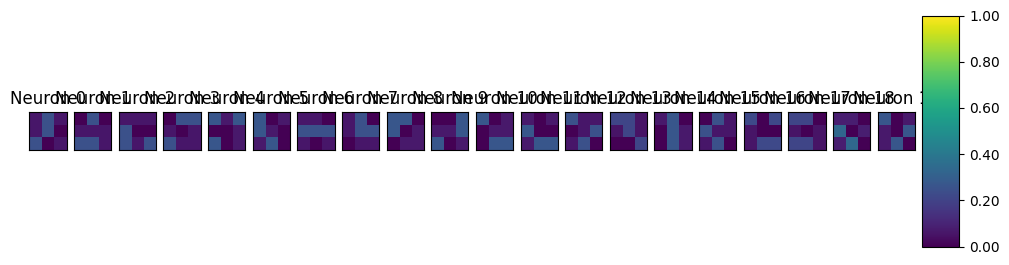

In [16]:
plot_ins(input_layer, exc_layer, stdp_synapses, inh_synapses)

Обучение

Training STDP weights has finished!


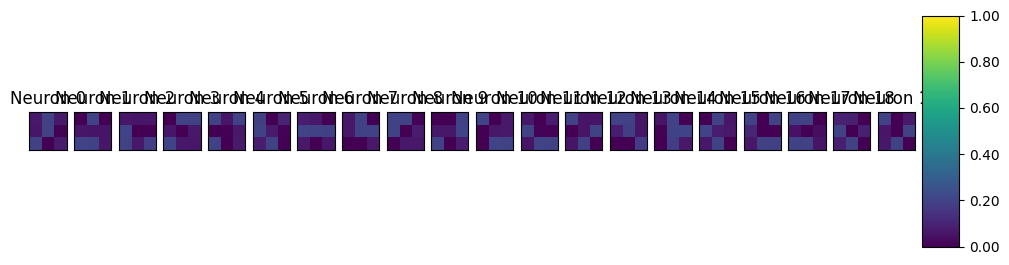

In [17]:
max_rate = 120 * b2.Hz # редактируется совместно с gmax
T_img = 150*b2.ms
T_rest = 50*b2.ms

for img in X_train:
#   показ изображения
  input_layer.rates = img.ravel()*max_rate
  b2.run(T_img, report=None)
#   отсутствие изображения
  input_layer.rates = img.ravel()*0*b2.Hz
  b2.run(T_rest, report=None)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

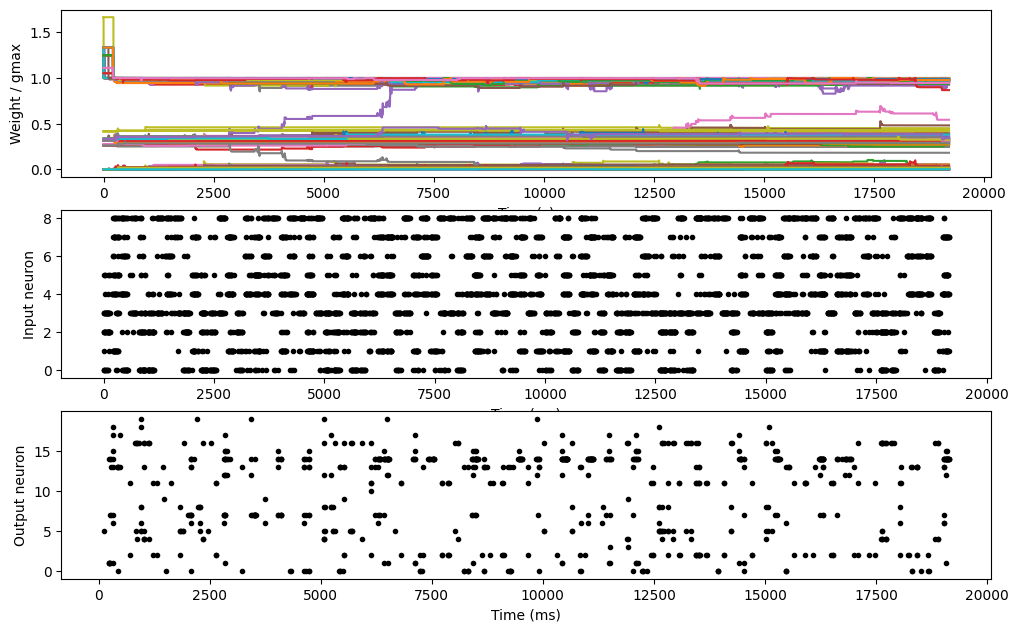

In [18]:
plot_info(mon_stdp, mon_input, mon_exc)

[3 1 0 3 2 2 0 1 2 3 0 0 1 3 1 1 2 3 2 2]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]]


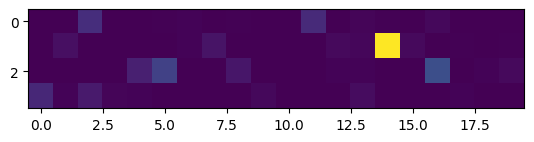

In [19]:
def evaluate(X):
  img_rates = np.zeros((len(X), len(exc_layer)))
  T_show = 150*b2.ms
  rate_mon = b2.SpikeMonitor(exc_layer)
  prev_count = np.zeros((len(exc_layer),))
  for i_img, img in enumerate(X):
    input_layer.rates = img.ravel()*max_rate
    b2.run(T_show, report=None)
    img_rates[i_img,:] = np.array(rate_mon.count-prev_count)
    prev_count += img_rates[i_img,:]
    input_layer.rates = img.ravel()*0*b2.Hz
    b2.run(T_rest, report=None)
    #del rate_mon
  return img_rates
  
stdp_synapses.stdp_rate = 0
train_rates = evaluate(X_train)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
  nrn_class_count[i_class,:] = np.sum(train_rates[np.equal(y_train,i_class),:], axis=0)
plt.imshow(nrn_class_count)  
neuron_class = np.argmax(nrn_class_count, axis=0)
print(neuron_class)
print(train_rates)

Проверка на обучающей выборке:

Количество несовпадающих объектов 13 из 96 (13 %)
Accuracy: 0.8645833333333334
f_1: 0.863986601766359


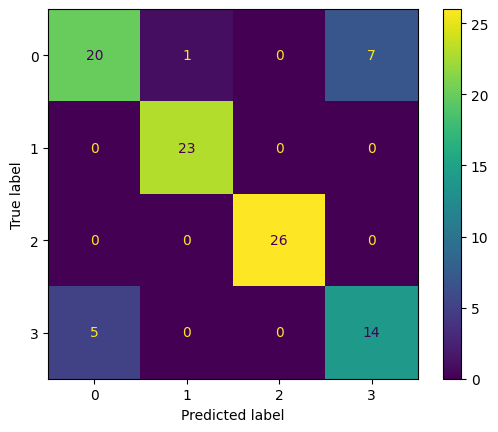

In [20]:
train_rates
train_prediction = predict(train_rates, neuron_class)
all_metrics(train_prediction, y_train)

Проверка на тестовой выборке:

Количество несовпадающих объектов 2 из 24 (8 %)
Accuracy: 0.9166666666666666
f_1: 0.9166666666666666


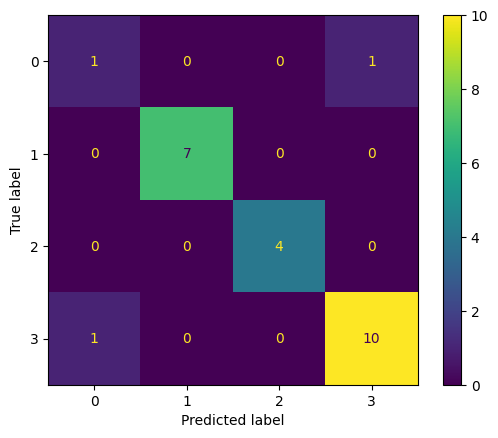

In [21]:
test_rates = evaluate(X_test)
test_prediction = predict(test_rates, neuron_class)
all_metrics(test_prediction, y_test)

# Временное кодирование TTFS
Яркость пикселя $r_i$ преобразуется во время спайка по правилу

$$
t_i=1/r_i
$$

In [22]:
gmax=0.6
gavg=0.3
gmin=0.0001

Создаем сеть

In [23]:
b2.start_scope()
input_layer, mon_input = create_input_SGG(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(5*len(patterns))
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)

# change w
stdp_synapses.w = change_w(stdp_synapses.w, patterns[0].size, [2]) 
# stdp_synapses.w = stdp_synapses.w * 0.5 / np.max(stdp_synapses.w)

inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)
b2.store() 

WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Input layer: 9 neurons
Excitatory layer: 20 neurons
180 STDP synapses
380 inhibitory synapses


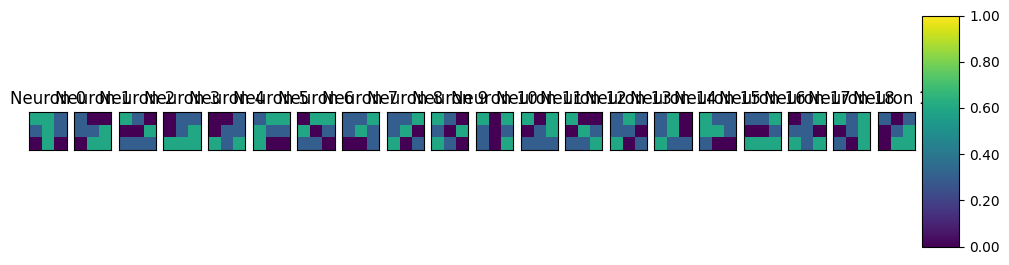

In [24]:
plot_ins(input_layer, exc_layer, stdp_synapses, inh_synapses)

Обучение

WARNING    /var/folders/zn/n2d2qpcj7qb1lmqnh250v_6w0000gn/T/ipykernel_2785/4254355823.py:9: RuntimeWarning: divide by zero encountered in divide
  times = np.ones((img.size,))/img.ravel() # Кодируем время спайков как обратное к яркости
 [py.warnings]


Training STDP weights has finished!


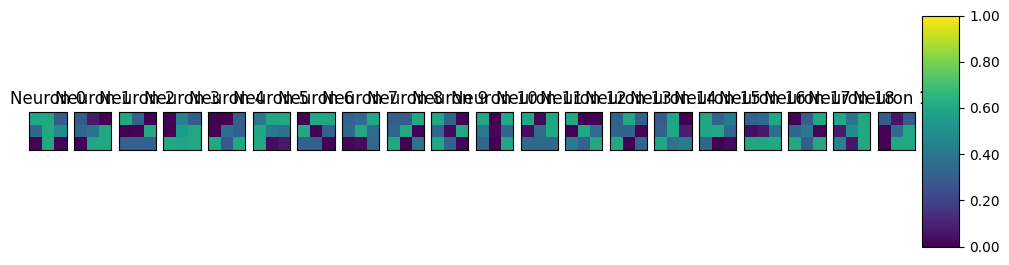

In [25]:
INF_TIME = 1000
t_min = 0.01*b2.ms
T_img = 50*b2.ms
T_rest = 30*b2.ms

indices = list(range(len(input_layer)))

def encode_ttfs_inverse(img):
  times = np.ones((img.size,))/img.ravel() # Кодируем время спайков как обратное к яркости
  times[times==np.inf] = INF_TIME
  return np.ones((img.size,))*t_min + times*b2.ms

def train(X):
  total_time = 0*b2.ms
  for img in X:
    times = total_time + encode_ttfs_inverse(img) # Время спайка
    input_layer.set_spikes(indices, times) # Заставляем пиксель спайковать в нужное время
    b2.run(T_img, report=None)
    total_time += T_img
    input_layer.set_spikes([], []*b2.ms)
    b2.run(T_rest, report=None)
    total_time += T_rest
  return total_time

b2.restore()
stdp_synapses.stdp_rate = 1
total_time = train(X)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

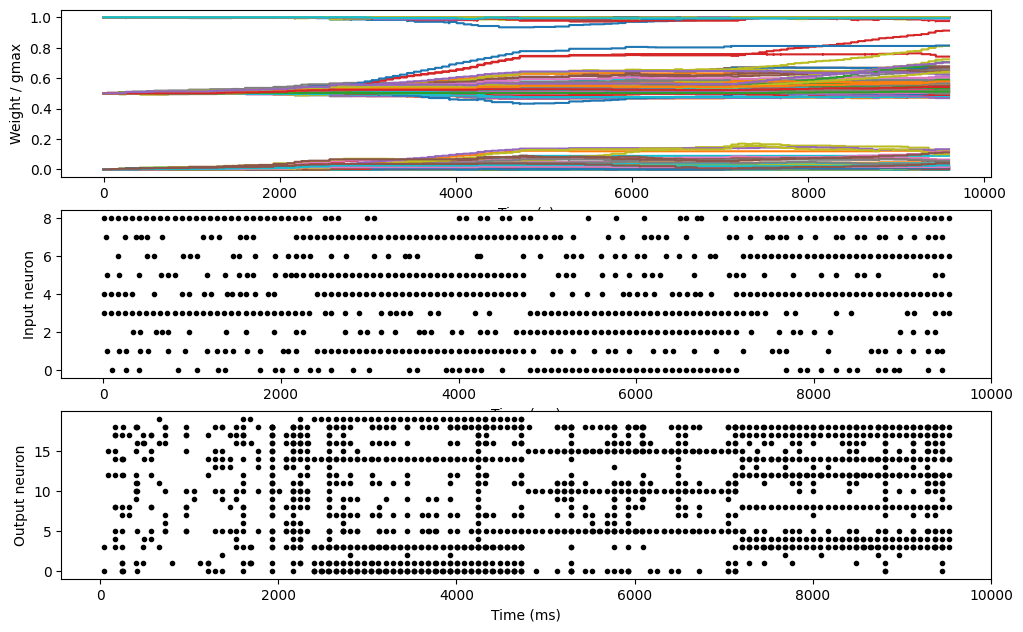

In [26]:
plot_info(mon_stdp, mon_input, mon_exc)

WARNING    /var/folders/zn/n2d2qpcj7qb1lmqnh250v_6w0000gn/T/ipykernel_2785/4254355823.py:9: RuntimeWarning: divide by zero encountered in divide
  times = np.ones((img.size,))/img.ravel() # Кодируем время спайков как обратное к яркости
 [py.warnings]


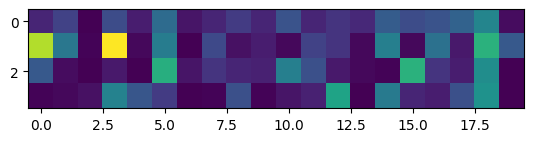

In [27]:
def evaluate(X, total_time):
  img_spike_count = np.zeros((len(X), len(exc_layer)))
  T_show = 50*b2.ms
  rate_mon = b2.SpikeMonitor(exc_layer)
  prev_count = np.zeros((len(exc_layer),))
  for i_img, img in enumerate(X):
    times = total_time + encode_ttfs_inverse(img)
    input_layer.set_spikes(indices, times)
    b2.run(T_show, report=None)
    total_time += T_show
    img_spike_count[i_img,:] = np.array(rate_mon.count-prev_count)
    prev_count += img_spike_count[i_img,:]
    input_layer.set_spikes([], []*b2.ms)
    b2.run(T_rest, report=None)
    total_time += T_rest
    #del rate_mon
  return img_spike_count, total_time
  
stdp_synapses.stdp_rate = 0
train_rates, total_time = evaluate(X_train, total_time)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
  nrn_class_count[i_class,:] = np.sum(train_rates[np.equal(y_train,i_class),:], axis=0)
plt.imshow(nrn_class_count)  
neuron_class = np.argmax(nrn_class_count, axis=0)
# print(neuron_class)
# print(train_rates)

Проверка на обучающей выборке:

Количество несовпадающих объектов 42 из 96 (43 %)
Accuracy: 0.5625
f_1: 0.5065104166666666


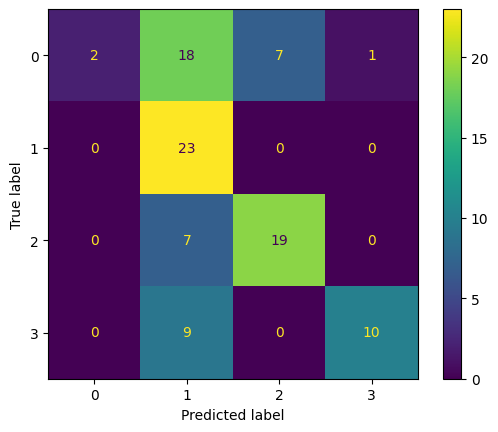

In [28]:
train_rates
train_prediction = predict(train_rates, neuron_class)
all_metrics(train_prediction, y_train)

Проверка на тестовой выборке:

WARNING    /var/folders/zn/n2d2qpcj7qb1lmqnh250v_6w0000gn/T/ipykernel_2785/4254355823.py:9: RuntimeWarning: divide by zero encountered in divide
  times = np.ones((img.size,))/img.ravel() # Кодируем время спайков как обратное к яркости
 [py.warnings]


Количество несовпадающих объектов 12 из 24 (50 %)
Accuracy: 0.5
f_1: 0.42935897435897435


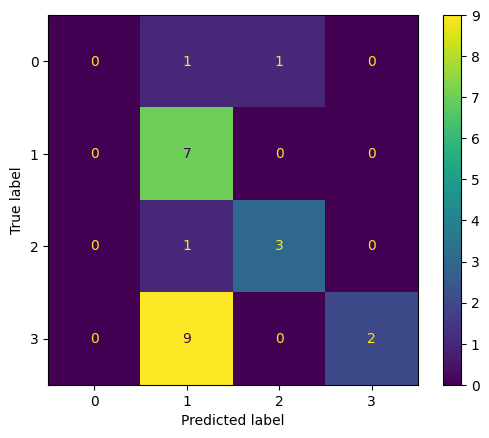

In [29]:
test_rates, total_time = evaluate(X_test, total_time)
test_prediction = predict(test_rates, neuron_class)
all_metrics(test_prediction, y_test)

# Итог
| | $\lambda r_i$ train | $\lambda r_i$ test | $\dfrac{1}{r_i}$ train | $\dfrac{1}{r_i}$ test |
| --- |--- |--- |--- |--- |
| Accuracy | 0.895 | 0.875 | 0.854 | 0.75 |
| F| 0.890 | 0.877 | 0.839 | 0.716 |

Основной упор был сделан на подбор случайно генерируемых весов на синапсе при создании сети. 

Получилось, что частотное кодирование работает лучше.

Возникшие проблемы: если один паттерн сильно совпадает с другими, то его может не распознать (на него реагируют те же нейроны, что и на похожий). Если паттерн состоит из одной или двух точек, то больше шанс того, что не повезет с весами на синапсе и на этот паттерн не будет реагировать ни один нейрон. 

Основные ошибки сети из-за первого изображения. Из-за небольшого количества ярких точек оно является самым сложным для сети.